### importing needed libaries 

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio
from datetime import datetime
import pytz
from scipy.stats import linregress

%matplotlib inline

In [49]:
df1 = pd.read_csv(r'C:\Users\DIMAGO\Desktop\crime\crime1.csv')
df2 = pd.read_csv(r'C:\Users\DIMAGO\Desktop\crime\crime2.csv')
df3 = pd.read_csv(r'C:\Users\DIMAGO\Desktop\crime\crime3.csv')
df = pd.concat([df1, df2, df3])

In [ ]:
df.head()

unique_key case_number                     date                   block  \
0     7345236    HS144775  2010-01-31 03:30:00 UTC       117XX S BISHOP ST   
1     7342973    HS145538  2010-01-31 03:45:00 UTC        063XX S LOWE AVE   
2     7342288    HS144801  2010-01-31 03:50:00 UTC         022XX W 47TH ST   
3     7342476    HS144959  2010-01-31 04:00:00 UTC  054XX S MARSHFIELD AVE   
4     7343161    HS144856  2010-01-31 04:00:00 UTC         040XX W 57TH PL   

   iucr     primary_type              description  \
0  1310  CRIMINAL DAMAGE              TO PROPERTY   
1  0320          ROBBERY    STRONGARM - NO WEAPON   
2  1320  CRIMINAL DAMAGE               TO VEHICLE   
3  0820            THEFT           $500 AND UNDER   
4  0486          BATTERY  DOMESTIC BATTERY SIMPLE   

            location_description  arrest  domestic  ...  community_area  \
0                      RESIDENCE    True      True  ...            53.0   
1                  BAR OR TAVERN   False     False  ...            68.0   
2  RESIDENTIAL YARD (FRONT/BACK)   False     False  ...            61.0   
3                         STREET   False     False  ...            61.0   
4                          ALLEY   False      True  ...            62.0   

   fbi_code  x_coordinate  y_coordinate  year               updated_on  \
0        14     1168774.0     1826991.0  2010  2018-02-10 15:50:01 UTC   
1        03     1173121.0     1863031.0  2010  2018-02-10 15:50:01 UTC   
2        14     1162122.0     1873463.0  2010  2018-02-10 15:50:01 UTC   
3        06     1166266.0     1868694.0  2010  2018-02-10 15:50:01 UTC   
4       08B     1150436.0     1866166.0  2010  2018-02-10 15:50:01 UTC   

    latitude  longitude                       location  row_num  
0  41.680778 -87.657836  (41.680778424, -87.657836326)  4105863  
1  41.779583 -87.640863  (41.779582501, -87.640862796)  4105866  
2  41.808445 -87.680896   (41.808445232, -87.68089632)  4105869  
3  41.795271 -87.665833  (41.795271206, -87.665832889)  4105872  
4  41.788657 -87.723948  (41.788656622, -87.723948048)  4105875  

[5 rows x 23 columns]

In [ ]:
# preperetion to data cleaning, we want to check the precentage of missing values o see if we can drop them 
has_missing_values = df.isnull().any(axis=1)

percent_missing_rows = len(df[has_missing_values]) / len(df) * 100

if percent_missing_rows > 0:
    print(f"The dataframe has {percent_missing_rows:.2f}% missing rows.")
else:
    print("The dataframe does not have any missing values in rows.")

The dataframe has 8.66% missing rows.


In [ ]:
# dropping missing values to have a clean data set  
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7439496 entries, 0 to 2714973
Data columns (total 23 columns):
 #   Column                Dtype  
---  ------                -----  
 0   unique_key            int64  
 1   case_number           object 
 2   date                  object 
 3   block                 object 
 4   iucr                  object 
 5   primary_type          object 
 6   description           object 
 7   location_description  object 
 8   arrest                bool   
 9   domestic              bool   
 10  beat                  int64  
 11  district              float64
 12  ward                  float64
 13  community_area        float64
 14  fbi_code              object 
 15  x_coordinate          float64
 16  y_coordinate          float64
 17  year                  int64  
 18  updated_on            object 
 19  latitude              float64
 20  longitude             float64
 21  location              object 
 22  row_num               int64  
dtypes: bool(2), 

### We can see that we have 91% clean data. Let's create a date, hour, and other columns for future analysis



In [ ]:

# the data is formated in utc we want to have an ap pm format in rder for easy modeling and for us to understand the data
df["timestamp"] = pd.to_datetime(df["date"])

# creating some extra column that we can use in our analasys 
df['date'] = df['timestamp'].dt.date
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute

# After creating the additional columns, create a readable string format column with AM/PM
#df["timestamp"] = df["timestamp"].apply(lambda x: x.strftime("%Y-%m-%d %I:%M:%S %p"))
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %I:%M:%S %p')
df.head()

unique_key case_number        date                   block  iucr  \
0     7345236    HS144775  2010-01-31       117XX S BISHOP ST  1310   
1     7342973    HS145538  2010-01-31        063XX S LOWE AVE  0320   
2     7342288    HS144801  2010-01-31         022XX W 47TH ST  1320   
3     7342476    HS144959  2010-01-31  054XX S MARSHFIELD AVE  0820   
4     7343161    HS144856  2010-01-31         040XX W 57TH PL  0486   

      primary_type              description           location_description  \
0  CRIMINAL DAMAGE              TO PROPERTY                      RESIDENCE   
1          ROBBERY    STRONGARM - NO WEAPON                  BAR OR TAVERN   
2  CRIMINAL DAMAGE               TO VEHICLE  RESIDENTIAL YARD (FRONT/BACK)   
3            THEFT           $500 AND UNDER                         STREET   
4          BATTERY  DOMESTIC BATTERY SIMPLE                          ALLEY   

   arrest  domestic  ...   latitude  longitude                       location  \
0    True      True  ...  41.680778 -87.657836  (41.680778424, -87.657836326)   
1   False     False  ...  41.779583 -87.640863  (41.779582501, -87.640862796)   
2   False     False  ...  41.808445 -87.680896   (41.808445232, -87.68089632)   
3   False     False  ...  41.795271 -87.665833  (41.795271206, -87.665832889)   
4   False      True  ...  41.788657 -87.723948  (41.788656622, -87.723948048)   

   row_num  timestamp  day  month  weekday hour  minute  
0  4105863 2010-01-31   31      1   Sunday    0       0  
1  4105866 2010-01-31   31      1   Sunday    0       0  
2  4105869 2010-01-31   31      1   Sunday    0       0  
3  4105872 2010-01-31   31      1   Sunday    0       0  
4  4105875 2010-01-31   31      1   Sunday    0       0  

[5 rows x 29 columns]

### Now that our data has been organized, we can proceed with examining it. Even though our objective is 
### to analyze the relationship between the year and primary type, we cannot do so without understanding the
### general direction of the data. We cannot dive into a specific analysis without first understanding the data.


In [ ]:
arrest_counts = df.groupby("year")["arrest"].sum().reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=arrest_counts["year"],
    y=arrest_counts["arrest"],
    name="Arrests",
    marker_color="#007bff"
))
fig.update_layout(
    title="Number of Arrests by Year",
    xaxis_title="Year",
    yaxis_title="Number of Arrests",
    font=dict(
        family="Arial, sans-serif",
        size=18,
        color="#333"
    )
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True, gridcolor="#ccc")
fig.show(renderer=pio.renderers.default)

In [ ]:

# year = 2023 & 2024 month=[1...9] (spetember not includer in order to not skew the data)
filtered_df = df[(df['year'].isin([2023, 2024])) & (df['month'] < 9)]
arrest_counts = filtered_df.groupby("year")["arrest"].sum().reset_index()
fig = go.Figure()
fig.add_trace(go.Bar(
    x=arrest_counts["year"],
    y=arrest_counts["arrest"],
    name="Arrests",
    marker_color="#007bff"
))

# our chart lay out 
fig.update_layout(
    title="Number of Arrests by Year (Up to September)",
    xaxis_title="Year",
    yaxis_title="Number of Arrests",
    font=dict(
        family="Arial, sans-serif",
        size=18,
        color="#333"
    )
)

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True, gridcolor="#ccc")

fig.show()

In [ ]:
# Calculate the totals for each type and hen we will see he  diff
arrests_2023 = arrest_counts.loc[arrest_counts['year'] == 2023, 'arrest'].values[0]
arrests_2024 = arrest_counts.loc[arrest_counts['year'] == 2024, 'arrest'].values[0]

percent_difference = ((arrests_2024 - arrests_2023) / arrests_2023) * 100

print(f"The percentage difference in arrests between 2024 and 2023 is {percent_difference:.2f}%.")

The percentage difference in arrests between 2024 and 2023 is 5.30%.


### Upon analyzing the data, I have observed a consistent decline in the number of incidents resulting 
### in arrests from the year 2001 onwards. However, starting from 2021, we can see the beginning of 
### an upward trend. Since 2024 is not a full year, we cannot examine it as a whole, but we will 
### compare the data from 2024 up to September (not including spetember in order to not skew the data) with data from 2023 to see if the spike in crime 
### continues in 2024. Additionally, we will investigate the incidents in which an arrest was not made.

### We can see that for the corresponding time periods of 2024 vs. 2023, 2024 shows an increase  in
### crime of around 5%. However, we need to take this assessment with a grain of salt as we 
### do not know what the future might bring. We could take it further with machine learning to 
### try to determine future values up to the end of 2024, but this is beyond the scope of this analysis.

In [ ]:
arrest_counts = df.groupby("year")["arrest"].count() - df.groupby("year")["arrest"].sum()
arrest_counts = arrest_counts.reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=arrest_counts["year"],
    y=arrest_counts["arrest"],
    name="No Arrest",
    marker_color="#dc3545"
))
fig.update_layout(
    title="Number of No Arrest by Year",
    xaxis_title="Year",
    yaxis_title="Number of No Arrests",
    font=dict(
        family="Arial, sans-serif",
        size=18,
        color="#333"
    )
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True, gridcolor="#ccc")
fig.show(renderer=pio.renderers.default)


### Based on our observations, there seems to be an overall downward trend in the number of incidents 
### resulting in no arrests made. However, starting from 2021, we can see the trend begin to shift
### upward with a steep rise in non-arrestable crimes. We will conduct the same analysis for 2024 vs.
### 2023 to see if this trend continues. It would also be worthwhile to examine the overall crime rate by tabulating the total number of arrests

In [ ]:


# the column in binary arrent=1 no arrest =0 so sum of arrest will be the arrest cases only totoal count - sum will ive us none arrst 
arrest_counts = filtered_df.groupby("year").agg(
    total_cases=("arrest", "count"),
    no_arrest_cases=("arrest", lambda x: (1 - x).sum())
).reset_index()

# % diff
no_arrests_2023 = arrest_counts.loc[arrest_counts['year'] == 2023, 'no_arrest_cases'].values[0]
no_arrests_2024 = arrest_counts.loc[arrest_counts['year'] == 2024, 'no_arrest_cases'].values[0]
percent_difference = ((no_arrests_2024 - no_arrests_2023) / no_arrests_2023) * 100
print(f"The percentage difference in no arrests between 2024 and 2023 is {percent_difference:.2f}%.")


fig = go.Figure()
fig.add_trace(go.Bar(
    x=arrest_counts["year"],
    y=arrest_counts["no_arrest_cases"],
    name="No Arrest",
    marker_color="#dc3545"
))


fig.update_layout(
    title="Number of No Arrests by Year (Up to September)",
    xaxis_title="Year",
    yaxis_title="Number of No Arrests",
    font=dict(
        family="Arial, sans-serif",
        size=18,
        color="#333"
    )
)


fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True, gridcolor="#ccc")


fig.show()

The percentage difference in no arrests between 2024 and 2023 is -4.98%.


### unlike arrestable crime we seem to be going down here 2023 vs 2024 by abount 5% 


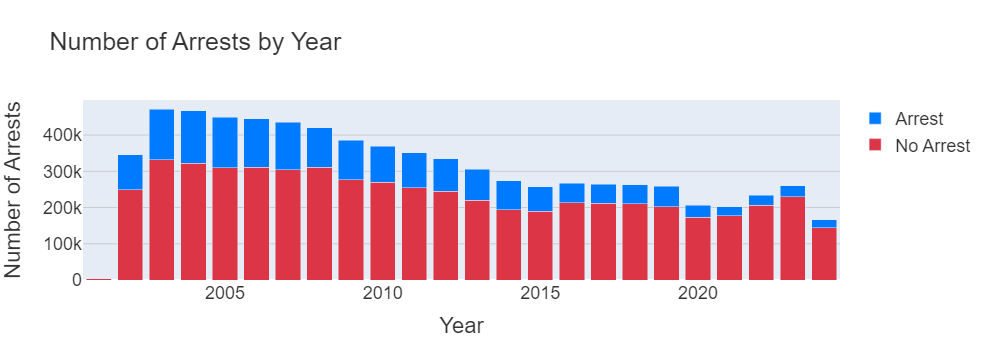

In [ ]:
arrest_counts = df.groupby("year")["arrest"].value_counts().unstack(fill_value=0)
arrest_counts = arrest_counts.reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=arrest_counts["year"],
    y=arrest_counts[False],
    name="No Arrest",
    marker_color="#dc3545"
))
fig.add_trace(go.Bar(
    x=arrest_counts["year"],
    y=arrest_counts[True],
    name="Arrest",
    marker_color="#007bff"
))
fig.update_layout(
    title="Number of Arrests by Year",
    xaxis_title="Year",
    yaxis_title="Number of Arrests",
    font=dict(
        family="Arial, sans-serif",
        size=18,
        color="#333"
    ),
    barmode="stack"
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True, gridcolor="#ccc")
fig.show(renderer=pio.renderers.default)


In [ ]:
arrest_counts = filtered_df.groupby("year")["arrest"].value_counts().unstack(fill_value=0)
arrest_counts = arrest_counts.reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=arrest_counts["year"],
    y=arrest_counts[False],
    name="No Arrest",
    marker_color="#dc3545"
))
fig.add_trace(go.Bar(
    x=arrest_counts["year"],
    y=arrest_counts[True],
    name="Arrest",
    marker_color="#007bff"
))
fig.update_layout(
    title="Number of Arrests by Year",
    xaxis_title="Year",
    yaxis_title="Number of Arrests",
    font=dict(
        family="Arial, sans-serif",
        size=18,
        color="#333"
    ),
    barmode="stack"
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True, gridcolor="#ccc")
fig.show(renderer=pio.renderers.default)


### My analysis indicates a consistent decline in crime rates from 2003 to 2014. However, 
### from 2014 to 2019, there appears to be no significant shift in overall crime rates. 
### Subsequently, between the years 2019 to 2021, we observe a significant decrease in 
### crime rates, which could be attributed to the implementation of lockdowns in response to the COVID-19 pandemic.

### This hypothesis could be further reinforced by examining the crime rates in 2022, when
### most COVID-19 restrictions were lifted, and a notable increase in crime rates was observed.
### It is essential to note that, based on the analysis done so far, 2024 seems to be experiencing
### a decrease in crime when comparing the same period of time. However, with the looming elections in the USA, 
### I cannot guarantee that the last few months of 2024 will not see a significant increase in crime, which is 
### often indicative of election periods. Now that we understand the overall trend and direction of crime in Chicago,
### this coreponds with the fact that aresable crime is on the rise (as we saw of avout 5%)
### we can dive deeper into the numbers and examine each crime type.


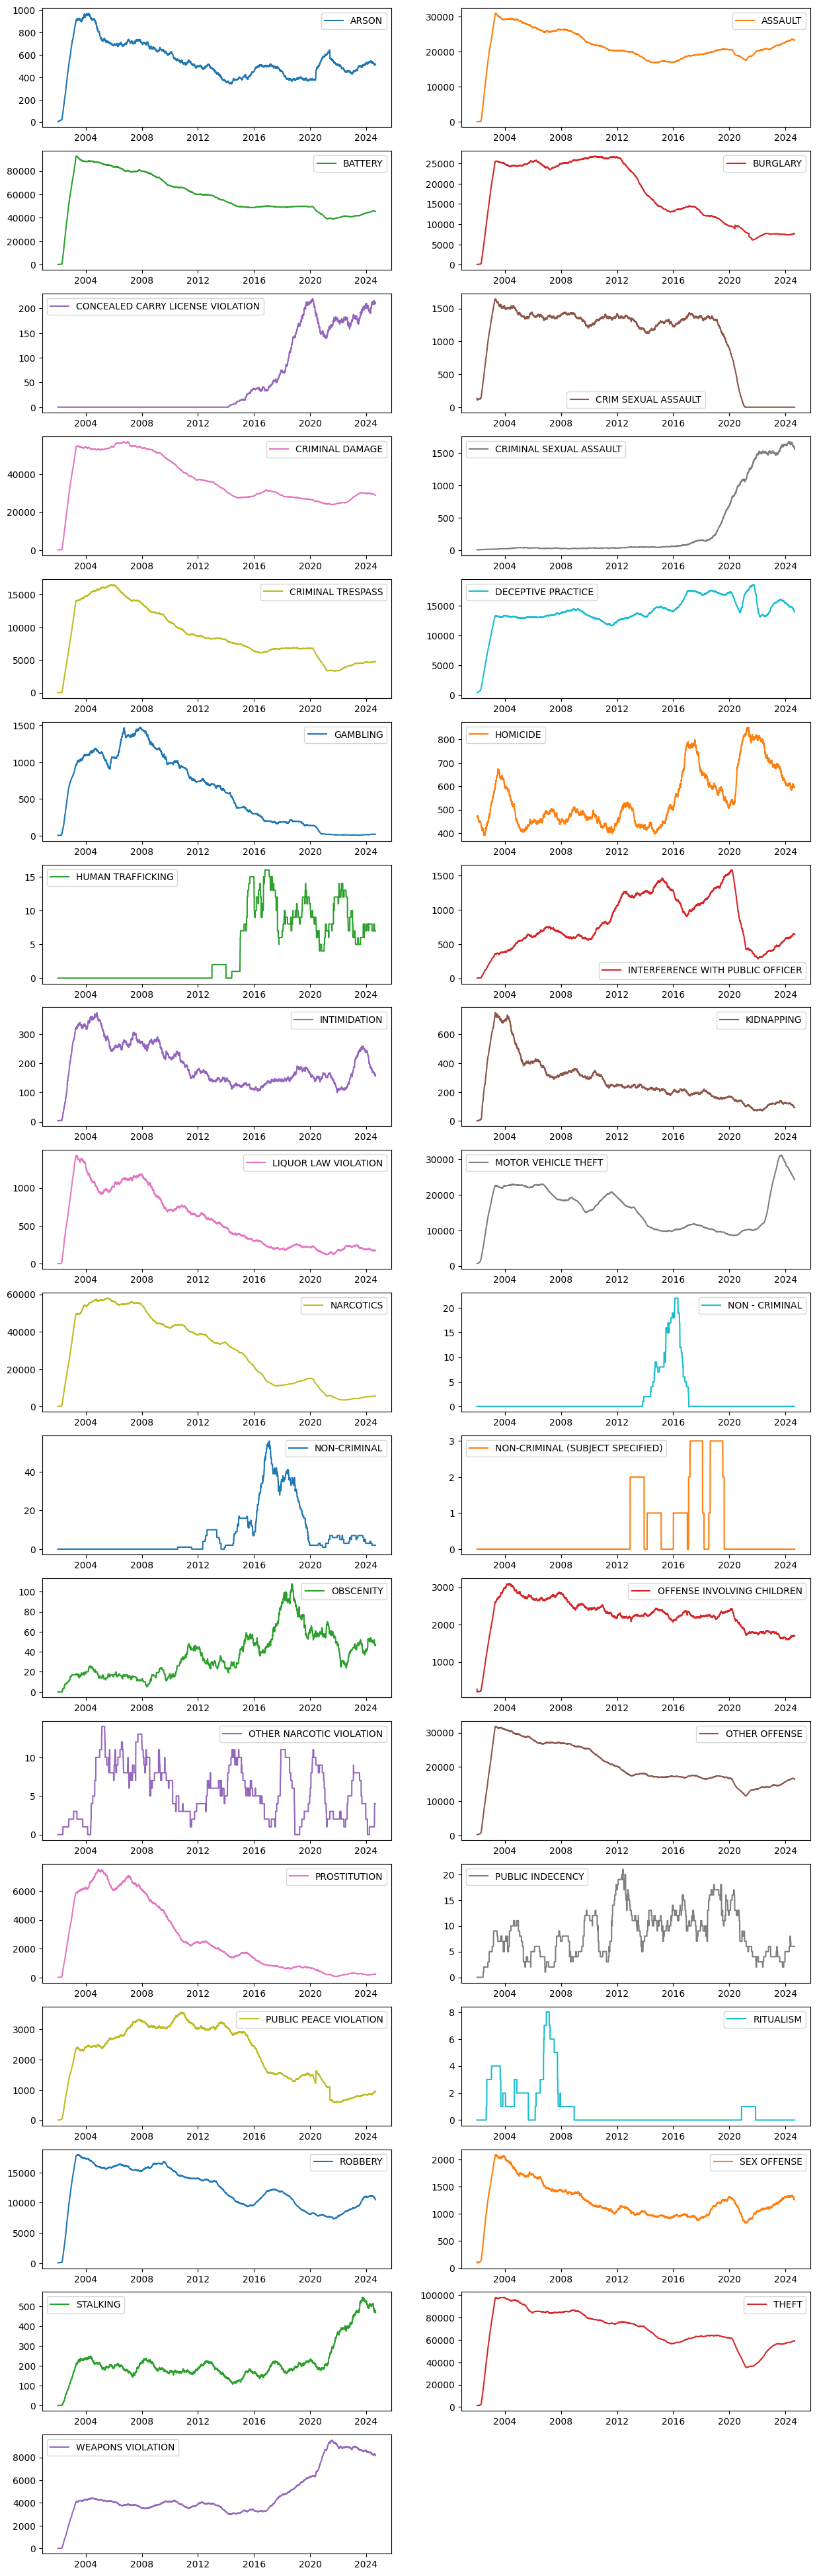

In [ ]:
crime_types = df[['timestamp', 'unique_key', 'primary_type']].copy()
crime_types['timestamp'] = pd.to_datetime(crime_types['timestamp'], format='%Y-%m-%d %I:%M:%S %p')
crime_types.index = pd.DatetimeIndex(crime_types['timestamp'])

# count pivot
crimes_count_date = crime_types.pivot_table(
    values='unique_key', 
    aggfunc=np.size, 
    columns='primary_type', 
    index=crime_types.index.date, 
    fill_value=0
)

crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)

plot = crimes_count_date.rolling(365).sum().plot(
    figsize=(15, 50), 
    subplots=True, 
    layout=(-1, 2),  
    sharex=False, 
    sharey=False
)

### Upon closer examination, it becomes evident that although there is an overall trend of 
### decreasing crime rates, certain categories of crimes are on the rise. These include 
### offenses such as weapons violations, stalking, sexual assault and others . 
### in light of this information, it would be prudent to allocate resources and budget towards combating 
### these specific types of crime that are experiencing an increase.

In [ ]:


crime_types = df[['timestamp', 'unique_key', 'primary_type']]
crime_types.index = pd.DatetimeIndex(crime_types['timestamp'])

# pivot
crimes_count_date = crime_types.pivot_table('unique_key', aggfunc=np.size, columns='primary_type', index=crime_types.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)

# rolling sum calculation 
rolling_crimes = crimes_count_date.rolling(365).sum()

trend_directions = {"up": 0, "down": 0, "flat": 0}
total_trends = len(rolling_crimes.columns)

individual_trends = {}

for crime_type in rolling_crimes.columns:

    valid_data = rolling_crimes[crime_type].dropna()
    
    # Calculate the slope of the trend using linear regression
    slope, intercept, r_value, p_value, std_err = linregress(range(len(valid_data)), valid_data.values)
    
    # insert the crime type into te coresponding slope type for that crime type (note to self: for future improvment flat slop should not be counted as 0 but +- DELTA )
    if slope > 0:
        trend_directions["up"] += 1
        individual_trends[crime_type] = "up"
    elif slope < 0:
        trend_directions["down"] += 1
        individual_trends[crime_type] = "down"
    else:
        trend_directions["flat"] += 1
        individual_trends[crime_type] = "flat"

percent_up = (trend_directions["up"] / total_trends) * 100
percent_down = (trend_directions["down"] / total_trends) * 100
percent_flat = (trend_directions["flat"] / total_trends) * 100

for crime_type, direction in individual_trends.items():
    print(f"The trend for {crime_type} is going {direction}.")

print(f"\nPercentage of trends:")
print(f"Up: {percent_up:.2f}%")
print(f"Down: {percent_down:.2f}%")
print(f"Flat: {percent_flat:.2f}%")

The trend for ARSON is going down.
The trend for ASSAULT is going down.
The trend for BATTERY is going down.
The trend for BURGLARY is going down.
The trend for CONCEALED CARRY LICENSE VIOLATION is going up.
The trend for CRIM SEXUAL ASSAULT is going down.
The trend for CRIMINAL DAMAGE is going down.
The trend for CRIMINAL SEXUAL ASSAULT is going up.
The trend for CRIMINAL TRESPASS is going down.
The trend for DECEPTIVE PRACTICE is going up.
The trend for GAMBLING is going down.
The trend for HOMICIDE is going up.
The trend for HUMAN TRAFFICKING is going up.
The trend for INTERFERENCE WITH PUBLIC OFFICER is going up.
The trend for INTIMIDATION is going down.
The trend for KIDNAPPING is going down.
The trend for LIQUOR LAW VIOLATION is going down.
The trend for MOTOR VEHICLE THEFT is going down.
The trend for NARCOTICS is going down.
The trend for NON - CRIMINAL is going up.
The trend for NON-CRIMINAL is going up.
The trend for NON-CRIMINAL (SUBJECT SPECIFIED) is going up.
The trend for

### This examination paints an even clearer picture: we can see that around 60% of crime has overall
### decreased through the years, while around 40% is on the rise. However, as we know, sometimes the
### macro picture doesn't tell the full story, which is exactly why we analyzed the overall data trends
### and saw that from 2021 onward, the crime trend started to rise again. Now, we will conduct the same 
### analysis but focus specifically on the period from 2021 and forward

In [ ]:



crime_types = df[['year', 'timestamp', 'unique_key', 'primary_type']]
crime_types = crime_types[crime_types['year'] >= 2021]
crime_types.index = pd.DatetimeIndex(crime_types['timestamp'])
crimes_count_date = crime_types.pivot_table('unique_key', aggfunc=np.size, columns='primary_type', index=crime_types.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
rolling_crimes = crimes_count_date.rolling(365).sum()
trend_directions = {"up": 0, "down": 0, "flat": 0}
total_trends = len(rolling_crimes.columns)
individual_trends = {}

for crime_type in rolling_crimes.columns:
    valid_data = rolling_crimes[crime_type].dropna()
    
    slope, intercept, r_value, p_value, std_err = linregress(range(len(valid_data)), valid_data.values)
    
    if slope > 0:
        trend_directions["up"] += 1
        individual_trends[crime_type] = "up"
    elif slope < 0:
        trend_directions["down"] += 1
        individual_trends[crime_type] = "down"
    else:
        trend_directions["flat"] += 1
        individual_trends[crime_type] = "flat"

percent_up = (trend_directions["up"] / total_trends) * 100
percent_down = (trend_directions["down"] / total_trends) * 100
percent_flat = (trend_directions["flat"] / total_trends) * 100

for crime_type, direction in individual_trends.items():
    print(f"The trend for {crime_type} is going {direction}.")

print(f"\nPercentage of trends:")
print(f"Up: {percent_up:.2f}%")
print(f"Down: {percent_down:.2f}%")
print(f"Flat: {percent_flat:.2f}%")


The trend for ARSON is going up.
The trend for ASSAULT is going up.
The trend for BATTERY is going up.
The trend for BURGLARY is going up.
The trend for CONCEALED CARRY LICENSE VIOLATION is going up.
The trend for CRIMINAL DAMAGE is going up.
The trend for CRIMINAL SEXUAL ASSAULT is going up.
The trend for CRIMINAL TRESPASS is going up.
The trend for DECEPTIVE PRACTICE is going up.
The trend for GAMBLING is going up.
The trend for HOMICIDE is going down.
The trend for HUMAN TRAFFICKING is going down.
The trend for INTERFERENCE WITH PUBLIC OFFICER is going up.
The trend for INTIMIDATION is going up.
The trend for KIDNAPPING is going up.
The trend for LIQUOR LAW VIOLATION is going down.
The trend for MOTOR VEHICLE THEFT is going up.
The trend for NARCOTICS is going up.
The trend for NON-CRIMINAL is going down.
The trend for OBSCENITY is going up.
The trend for OFFENSE INVOLVING CHILDREN is going down.
The trend for OTHER NARCOTIC VIOLATION is going down.
The trend for OTHER OFFENSE is go

In [ ]:
df.head()


unique_key case_number                      date                   block  \
0     7345236    HS144775 2010-01-31 00:00:00+00:00       117XX S BISHOP ST   
1     7342973    HS145538 2010-01-31 00:00:00+00:00        063XX S LOWE AVE   
2     7342288    HS144801 2010-01-31 00:00:00+00:00         022XX W 47TH ST   
3     7342476    HS144959 2010-01-31 00:00:00+00:00  054XX S MARSHFIELD AVE   
4     7343161    HS144856 2010-01-31 00:00:00+00:00         040XX W 57TH PL   

   iucr     primary_type              description  \
0  1310  CRIMINAL DAMAGE              TO PROPERTY   
1  0320          ROBBERY    STRONGARM - NO WEAPON   
2  1320  CRIMINAL DAMAGE               TO VEHICLE   
3  0820            THEFT           $500 AND UNDER   
4  0486          BATTERY  DOMESTIC BATTERY SIMPLE   

            location_description  arrest  domestic  ...   latitude  longitude  \
0                      RESIDENCE    True      True  ...  41.680778 -87.657836   
1                  BAR OR TAVERN   False     False  ...  41.779583 -87.640863   
2  RESIDENTIAL YARD (FRONT/BACK)   False     False  ...  41.808445 -87.680896   
3                         STREET   False     False  ...  41.795271 -87.665833   
4                          ALLEY   False      True  ...  41.788657 -87.723948   

                        location  row_num  timestamp  day  month  weekday  \
0  (41.680778424, -87.657836326)  4105863 2010-01-31   31      1   Sunday   
1  (41.779582501, -87.640862796)  4105866 2010-01-31   31      1   Sunday   
2   (41.808445232, -87.68089632)  4105869 2010-01-31   31      1   Sunday   
3  (41.795271206, -87.665832889)  4105872 2010-01-31   31      1   Sunday   
4  (41.788656622, -87.723948048)  4105875 2010-01-31   31      1   Sunday   

  hour  minute  
0    0       0  
1    0       0  
2    0       0  
3    0       0  
4    0       0  

[5 rows x 29 columns]

### as we suspected we can now see a totally diffrent picure and overwhelming  rise in most crime types almost 80% 

In [ ]:
# Convert 'date' column to datetime before filtering
df['date'] = pd.to_datetime(df['date'], utc=True)

# Filter for records from 2021 and onwards
filtered_df = df[df['date'].dt.year < 2024]

# Extract the hour from the 'date' column in the filtered DataFrame
filtered_df['hour'] = filtered_df['date'].dt.hour

# Group by hour and count the number of True, False, and total arrests
grouped = filtered_df.groupby('hour')['arrest'].value_counts().unstack().fillna(0)

# Check and handle boolean values in 'arrest' column
if True in grouped.columns and False in grouped.columns:
    grouped['total'] = grouped[True] + grouped[False]
else:
    grouped[True] = grouped.get(1.0, 0)  # Handle True if stored as 1
    grouped[False] = grouped.get(0.0, 0)  # Handle False if stored as 0
    grouped['total'] = grouped[True] + grouped[False]

# Create the interactive Plotly line chart
fig = go.Figure()

# Add lines for True and False arrests
fig.add_trace(go.Scatter(x=grouped.index, y=grouped[True], name='Arrest = True', mode='lines+markers'))
fig.add_trace(go.Scatter(x=grouped.index, y=grouped[False], name='Arrest = False', mode='lines+markers'))

# Add total line for comparison
fig.add_trace(go.Scatter(x=grouped.index, y=grouped['total'], name='Total Arrests', mode='lines+markers'))

# Customize the layout
fig.update_layout(
    title='Number of Crimes per Hour',
    xaxis_title='Hour of Day',
    yaxis_title='Number of Crimes',
    hovermode='x unified',
    template='plotly_white'
)

# Show the interactive chart
fig.show()

C:\Users\DIMAGO\AppData\Local\Temp\1\ipykernel_12708\3923885475.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Last time, I encountered a bug in the dataset. This time, we can conduct a full analysis of crime per hour.
### We can clearly see a rise in crime starting in the morning, peaking around noon, 
### and decreasing from 22:00 onwards. This is a bit counterintuitive because we tend to believe that nighttime 
### is always more dangerous, but as we can see here, it is overall safer. However, it would be interesting to analyze how each crime type behaves throughout the day


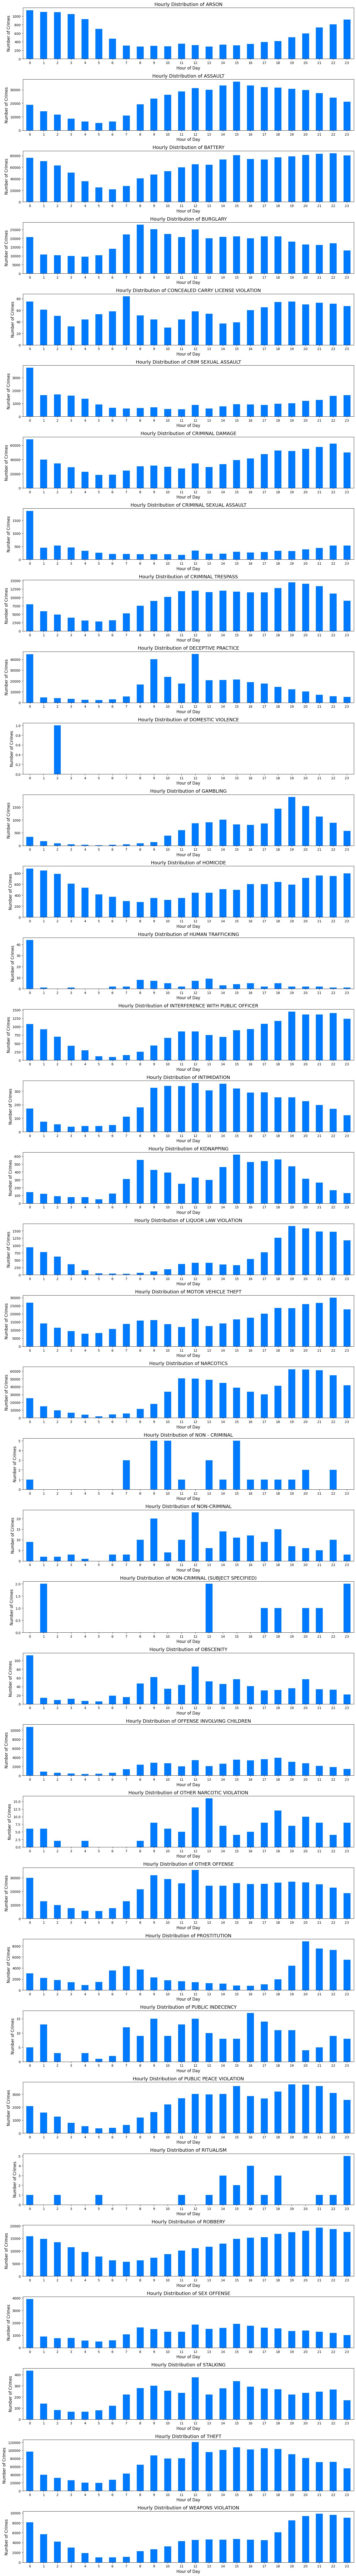

In [ ]:

df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %I:%M:%S %p')

# Extract the hour from the 'date' column
df['hour'] = df['date'].dt.hour

# Group by 'primary_type' and 'hour' to get the hourly counts of each crime type
hourly_counts = df.groupby(['primary_type', 'hour']).size().unstack(fill_value=0)

# Proceed with plotting as before
fig, axes = plt.subplots(nrows=len(hourly_counts.index), ncols=1, figsize=(15, len(hourly_counts.index) * 3))

if len(hourly_counts.index) == 1:
    axes = [axes]

for ax, crime_type in zip(axes, hourly_counts.index):
    hourly_counts.loc[crime_type].plot(kind='bar', ax=ax, color='#007bff')
    ax.set_title(f'Hourly Distribution of {crime_type}', fontsize=14)
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Number of Crimes', fontsize=12)
    ax.set_xticks(range(24))
    ax.set_xticklabels(range(24), rotation=0)

plt.tight_layout()
plt.show()

### Interestingly, we can see that crimes we would consider violent do seem to rise ater dark.
### I guess people's intuitions is correct here. 😊

# Comparing to the last time we conducted this analysis


### 1. Our last analysis was conducted at the beginning of 2023, and 
### even then, we predicted a spike in the crime rate. As we can see 
### from the data, 2023 indeed did not disappoint, as the spike in 
### crime rate has become much more evident.

### 2. Last time, we had only partial data and lacked information from 
### 13:00 to 12:00, which definitely had a huge skewing effect on the
 ### trends in crime types.

### 3. We can see that violent crimes, which tend to occur more
### frequently at night, were most affected by this skew.